# Ocean Mask

Notebook to change values of the ocean_mask.tif file. Goals is to make a few versions and see why the plume model is currently pluming onto land.

Cascade Tuholske 2020.01.19

- ocean_mask_orginal.tif : ocean = 1, land = 0 ... first step is to switch the zeros and ones for ocean/land and see if the plume will work. It came from: `/home/shares/ohi/marine_threats/impact_layers_2013_redo/impact_layers/work/land_based/scripts_and_intermediary_layers/[0]_og_input/ocean_mask`

- **The ocean_mask we want to use in the plume models : ocean = 1, land = nan.**

The notebook also allows for the isolation of the coastline from the ocean mask (see below). This will **NOT** be used with the river raster because it needs to be in ESPG:54009, where as the ocean mask is in ESPG:4326.



In [9]:
import numpy as np
import pandas as pd
import rasterio
import geopandas as gpd
from rasterio import features
from shapely.geometry import shape
import matplotlib.pyplot as plt

In [2]:
DATA_IN = '/home/cascade/projects/wastewater/data/interim/ocean_masks/'
DATA_OUT = '/home/cascade/projects/wastewater/data/interim/ocean_masks/'

# Switch Zeros & Ones

In [ ]:
FN_IN = 'ocean_mask_orginal.tif'

In [ ]:
org = rasterio.open(DATA_IN+FN_IN)

In [ ]:
org.meta

In [ ]:
org_arr = org.read(1)

In [ ]:
print('len land (0) is ', len(org_arr[org_arr == 0]))
print('len ocean (1) is ', len(org_arr[org_arr == 1]))

In [ ]:
### Switch zeros and ones

mask = org.read(1)
mask[mask == 1] = 2 # set ocean from 1 to 2 
mask[mask == 0] = 3 # set land from 0 to 3

mask[mask == 2] = 0 # set ocean from 2 to 0
mask[mask == 3] = 1 # set land from 3 to 1

In [ ]:
### write it out

# Get met & update type
kwargs = org.meta
#kwargs.update({'dtype' : 'float64'})


file_out = DATA_OUT+'ocean_mask_land1.tif'

with rasterio.open(file_out, 'w', **kwargs) as dst:
    dst.write_band(1, mask)

In [ ]:
### Set land to null and keep ocean as 1

mask = org.read(1)
mask = mask.astype(float)
mask[mask==0] = np.nan # land from 0 to nan

In [ ]:
# print('len land is (1)', len(mask[mask == 1]))
# print('len ocean is (0)', len(mask[mask == 0]))

print('len ocean is (1)', len(mask[mask == 1]))
print('len land is (nan)', len(mask[np.isnan(mask)]))

In [ ]:
org.meta

In [ ]:
### write it out

# Get met & update data type to allow nan
kwargs = org.meta
kwargs.update({'dtype' : 'float64'})


file_out = DATA_OUT+'ocean_mask_landnull.tif'

with rasterio.open(file_out, 'w', **kwargs) as dst:
    dst.write_band(1, mask)

In [ ]:
### Check it 
landnull = rasterio.open(file_out)

In [ ]:
landnull.read(1)

# Isolate coastlines within ocean masks

Here we use sk-image to erode the ocean mask by one pixel, then we subtract this eroded ocean mask from the original, leaving just the coastlines. 

The coastline will be integrated in with the rivers raster (see cpt_RiverRaster.ipynb

In [ ]:
from skimage.morphology import erosion

In [ ]:
### Set ocean to zero and land to one

mask = org.read(1)
mask[mask == 1] = 2 # set ocean from 1 to 2 
mask[mask == 0] = 3 # set land from 0 to 3

mask[mask == 2] = 0 # set ocean from 2 to 0
mask[mask == 3] = 1 # set land from 3 to 1

In [ ]:
a = mask # get land values set to 1

In [ ]:
b = erosion(mask) # erode land in-ward by 1-km

In [ ]:
# write it out to check it

kwargs = org.meta

file_out = DATA_OUT+'ocean_mask_land1_erosion1.tif'
with rasterio.open(file_out, 'w', **kwargs) as dst:
    dst.write_band(1, b)

In [ ]:
# Isolate coastline values

a[a == 1] = 2 # up the values and then subtract
c = a - b

In [ ]:
np.unique(c)

In [ ]:
# We want to keep 2 as the coastline
c[c == 1] = 0

In [ ]:
np.unique(c)

In [ ]:
# write it out to check it

kwargs = org.meta

file_out = DATA_OUT+'ocean_mask_coastline.tif'
with rasterio.open(file_out, 'w', **kwargs) as dst:
    dst.write_band(1, c)

# Coastlines into polygons 

In [5]:
FN_IN = 'ocean_mask_land1.tif'

In [6]:
coastline = rasterio.open(DATA_IN+FN_IN)

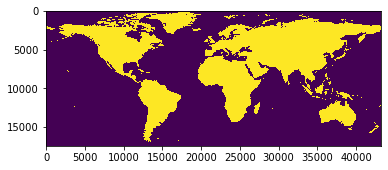

In [13]:
plt.imshow(coastline.read(1))

In [ ]:
import numpy as np
import fiona
import rasterio
import rasterio.features
from shapely.geometry import shape, mapping
from shapely.geometry.multipolygon import MultiPolygon

# Read input band with Rasterio
with rasterio.open(DATA_IN+FN_IN) as src:
    crs = src.crs
    src_band = src.read(1)
    # Keep track of unique pixel values in the input band
    unique_values = np.unique(src_band)
    # Polygonize with Rasterio. `shapes()` returns an iterable
    # of (geom, value) as tuples
    shapes = list(rasterio.features.shapes(src_band, transform=src.transform))


shp_schema = {
    'geometry': 'MultiPolygon',
    'properties': {'pixelvalue': 'int'}
}

# Get a list of all polygons for a given pixel value
# and create a MultiPolygon geometry with shapely.
# Then write the record to an output shapefile with fiona.
# We make use of the `shape()` and `mapping()` functions from
# shapely to translate between the GeoJSON-like dict format
# and the shapely geometry type.
with fiona.open('output.shp', 'w', 'ESRI Shapefile', shp_schema, crs) as shp:
    for pixel_value in unique_values:
        polygons = [shape(geom) for geom, value in shapes
                    if value == pixel_value]
        multipolygon = MultiPolygon(polygons)
        shp.write({
            'geometry': mapping(multipolygon),
            'properties': {'pixelvalue': int(pixel_value)}
        })